# Setup

## Mounting Google Drive (optional)

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # mount drive

# Check to see if using a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU.')
  print('It is highly recommended you change your runtime type from CPU (standard) to GPU.')

Mounted at /content/drive


## Libraries

In [ ]:
try: # Try to import the Adversarial Robustness Toolbox (ART)
  __import__('art')
except ImportError: # Install it
  !pip install Adversarial-Robustness-Toolbox

from art.attacks.evasion import ProjectedGradientDescent # PGD attack
from art.estimators.classification import KerasClassifier # Keras-based classifier for ART
from art.defences.trainer import AdversarialTrainer # Adversarial trainer, generates attacks and trains models with attacks

import tensorflow
from tensorflow.keras.models import load_model # Import previously trained models

from tabulate import tabulate # Print table output
import pickle # Save/load data
import pandas as pd # Load CSVs
import matplotlib.pyplot as plt # Plot figures and images
from IPython.display import clear_output # Clear output from display
import numpy as np # Numpy arrays for images

tensorflow.compat.v1.disable_eager_execution() # Disable eager execution for compatibility with ART

## Setting paths/directories/variables

In [ ]:
# ========= Prerequisites, these files are from other notebooks
DATA_PATH = 'drive/My Drive/Colab Notebooks/data.pickled' # Data path for output from data_loader.ipynb
NAME_LIST_PATH = 'drive/My Drive/Colab Notebooks/LFW/name_list.csv' # CSV with names, came with LFW

VGGNET_PATH = 'drive/My Drive/Colab Notebooks/vggnet.h5' # Trained VGG16 model from BinaryInputDetectionDefense.ipynb
ADV_ATTACK_INDICES_PATH = 'drive/My Drive/Colab Notebooks/adv_attack_indices.pickled'
FGSM_ATTACK_PATH = 'drive/My Drive/Colab Notebooks/fgsm_attack.pickled'
PGD_ATTACK_PATH = 'drive/My Drive/Colab Notebooks/pgd_attack.pickled'
DEEPFOOL_ATTACK_PATH = 'drive/My Drive/Colab Notebooks/deepfool_attack.pickled'
PIXEL_ATTACK_PATH = 'drive/My Drive/Colab Notebooks/pixel_attack.pickled'

# ========= These files are not prerequisites. If they do not exist they will be generated.
VGGNET_ADV_PATH = 'drive/My Drive/Colab Notebooks/vggnet_adv.h5' 
ARNOLD_INDEX = 980
NOISY_ARNOLD_PATH = 'drive/My Drive/Colab Notebooks/noisy_arnold.jpg'

BATCH_SIZE = 32 # Training batch size
IMG_SHAPE = (100, 100, 3) # Single image shape
SINGLE_IMG_BATCH_SIZE = (1, 100, 100, 3) # Shape of batch with a single image

## Load data

In [ ]:
try: # Load the data
  with open(DATA_PATH, 'rb') as infile:
    x_train, y_train, x_test, y_test, x_val, y_val = pickle.load(infile)
except FileNotFoundError as error:
  print(error)
  print(f'Data could not be found at "{DATA_PATH}". Did you run the "data_loader.ipynb" notebook?')

try: # Load the previously trained VGG16 model
  vggnet = load_model(VGGNET_PATH)
except:
  print(f'Trained VGG16 model could not be loaded from "{VGGNET_PATH}". Did you run the "BinaryInputDetectionDefense.ipynb" notebook?')

try: # Load the attacks
  with open(ADV_ATTACK_INDICES_PATH, 'rb') as infile:
    adv_indices = pickle.load(infile)
  with open(FGSM_ATTACK_PATH, 'rb') as infile:
    x_adv_fgsm = pickle.load(infile)
  with open(PGD_ATTACK_PATH, 'rb') as infile:
    x_adv_pgd = pickle.load(infile)
  with open(DEEPFOOL_ATTACK_PATH, 'rb') as infile:
    x_adv_deepfool = pickle.load(infile)
  with open(PIXEL_ATTACK_PATH, 'rb') as infile:
    x_adv_pixel = pickle.load(infile)
except FileNotFoundError:
  print(f'Adversarial images could not be loaded. Did you run the "BinaryInputDetectionDefense.ipynb" notebook?')


# Load the classes
CLASSES = pd.read_csv(NAME_LIST_PATH).values
CLASSES = [i[1] for i in CLASSES]
NUM_CLASSES = len(CLASSES)

## Double-checking data

In [ ]:
print('Testing data shapes')
print(f'X: {x_test.shape}')
print(f'y: {y_test.shape}\n')

print('Training data shapes')
print(f'X: {x_train.shape}')
print(f'y: {y_train.shape}\n')

print('Validation data shapes')
print(f'X: {x_val.shape}')
print(f'y: {y_val.shape}\n')

Testing data shapes
X: (1049, 100, 100, 3)
y: (1049, 62)

Training data shapes
X: (3043, 100, 100, 3)
y: (3043, 62)

Validation data shapes
X: (1021, 100, 100, 3)
y: (1021, 62)



## Functions

In [ ]:
# Same as in BinaryInputDetectionDefense.ipynb
# Splits large batches into smaller batches to avoid exhausting all GPU memory
def test_on_batches(x, y, model, increment=1000):
  start = 0
  acc = 0.0
  while True:
    end = start + increment
    if end > x.shape[0]:
      batch_acc = model.test_on_batch(x=x[start:], y=y[start:])[1]
      acc += batch_acc * ((x.shape[0] - start) / x.shape[0])
      break

    acc += (model.test_on_batch(x=x[start:end], y=y[start:end])[1] * (increment / x.shape[0]))
    start += increment
  return acc

# Task 1

## Step 1

In [ ]:
# Create table
acc = [[0] * 6, [0] * 6]

# Test undefended model on different attacks
acc[0][0] = test_on_batches(x=x_train, y=y_train, model=vggnet)
acc[0][1] = test_on_batches(x=x_test[adv_indices], y=y_test[adv_indices], model=vggnet)
acc[0][2] = test_on_batches(x=x_adv_fgsm, y=y_test[adv_indices], model=vggnet)
acc[0][3] = test_on_batches(x=x_adv_pgd, y=y_test[adv_indices], model=vggnet)
acc[0][4] = test_on_batches(x=x_adv_deepfool, y=y_test[adv_indices], model=vggnet)
acc[0][5] = test_on_batches(x=x_adv_pixel, y=y_test[adv_indices], model=vggnet)

## Step 2

In [ ]:
try: # Load adversarially-trained model
  vggnet_adv = load_model(VGGNET_ADV_PATH)
except: # Adversarially-train the undefended model
  attacks = ProjectedGradientDescent(KerasClassifier(vggnet), eps=5.0/255, eps_step=0.01, max_iter=40) # Use the PGD attack
  trainer = AdversarialTrainer(classifier=KerasClassifier(model=vggnet), attacks=attacks, ratio=0.1) # Create the trainer
  trainer.fit(x_train, y_train, nb_epochs=40, batch_size=BATCH_SIZE) # Train the undefended model

  vggnet.save(VGGNET_ADV_PATH) # Save the defended model
  vggnet = load_model(VGGNET_PATH) # Relaod the undefended model (it was overwritten by the trainer)
  vggnet_adv = load_model(VGGNET_ADV_PATH) # Load the defended model separately

## Step 3

In [ ]:
# Test adversarially trained model on different attacks
acc[1][0] = test_on_batches(x=x_train, y=y_train, model=vggnet_adv)
acc[1][1] = test_on_batches(x=x_test[adv_indices], y=y_test[adv_indices], model=vggnet_adv)
acc[1][2] = test_on_batches(x=x_adv_fgsm, y=y_test[adv_indices], model=vggnet_adv)
acc[1][3] = test_on_batches(x=x_adv_pgd, y=y_test[adv_indices], model=vggnet_adv)
acc[1][4] = test_on_batches(x=x_adv_deepfool, y=y_test[adv_indices], model=vggnet_adv)
acc[1][5] = test_on_batches(x=x_adv_pixel, y=y_test[adv_indices], model=vggnet_adv)

acc = [[f'{round(j * 100, 2)}%' for j in i] for i in acc] # Make the numbers look good (.9012235 => 90.12%)

# Add row labels
acc[0].insert(0, 'VGG16 classifier')
acc[1].insert(0, 'Adversarially trained classifier')

# Create and print the table
table = [
  ['', 'Clean train images', 'Clean subset of test images', 'FGSM attacked subset of test images', 'PGD attacked subset of test images', 'DF attacked subset of test images', 'Pixel attacked subset of test images'],
  acc[0],
  acc[1]
]

print(tabulate(table))

--------------------------------  ------------------  ---------------------------  -----------------------------------  ----------------------------------  ---------------------------------
                                  Clean train images  Clean subset of test images  FGSM attacked subset of test images  PGD attacked subset of test images  DF attacked subset of test images
VGG16 classifier                  100.0%              97.0%                        29.0%                                12.0%                               8.0%
Adversarially trained classifier  100.0%              94.0%                        89.0%                                91.0%                               27.0%
--------------------------------  ------------------  ---------------------------  -----------------------------------  ----------------------------------  ---------------------------------


# Task 2

In [ ]:
# Function for generating adversarial images with PGD
# Same as in BinaryInputDetectionDefense.ipynb EXCEPT...
#   it generates an attack with a single image instead of multiple
def get_adv_image_PGD(classifier, image, epsilon, target=None):
  image_batch = image.reshape(SINGLE_IMG_BATCH_SIZE)
  if (target is None):
    attacker = ProjectedGradientDescent(estimator=classifier, eps=epsilon, targeted=False)
    x_attack = attacker.generate(x=image_batch)
  else:
    attacker = ProjectedGradientDescent(estimator=classifier, eps=epsilon, targeted=True)
    x_attack = attacker.generate(x=image_batch, y=target)
  return x_attack.reshape(IMG_SHAPE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Smallest working epsilon: 0.026470588235294117


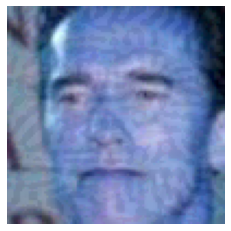

Image saved to drive/My Drive/Colab Notebooks/noisy_arnold.jpg


In [ ]:
# Makes a binary search to find the image with the smallest amount of perturbation needed
#   in order to fool the model (using a certain amount of steps)

arnold_img = x_test[980] # Load the Arnold image from the dataset
num_steps = 10 # Set the number of steps
step_size = 64 / 255.0 # Step size (how much the epsilon is increased/decreased)
current_epsilon = 128.0 / 255 # The current epsilon
smallest_working_epsilon = 128 # Stores the smallest working epsilon

classifier = KerasClassifier(model=vggnet) # Keras-based ART classifier
for i in range(num_steps): # Loop through each step
  clear_output() # Clear the output (too much output otherwise)
  # Attack the Arnold image with the current epsilon
  noisy_arnold = get_adv_image_PGD(classifier=classifier, image=arnold_img, epsilon=current_epsilon)

  print(f'Epsilon: {current_epsilon}') # Print the epsilon
  fig = plt.imshow(noisy_arnold) # Show the picture
  # Turn axes off
  plt.axis('off')
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.savefig(NOISY_ARNOLD_PATH, bbox_inches='tight', pad_inches = 0) # Save the image
  plt.show() # Show the figure

  # The user must then download the image and upload it to the website to test if the attack worked

  response = input(f'Image was saved to {NOISY_ARNOLD_PATH}. Did it fool the network (Y/n)? ') # Get a response from the user
  while response.upper() not in ['N', 'Y', 'NO', 'YES']: # Make sure the reponse is valid
    response = input(f'Response "{response}" is invalid. Try again (Y/n): ')
  if response.upper() in ['N', 'NO']: # If the website was not fooled...
    current_epsilon += step_size # Increase the epsilon
  else: # Otherwise
    # Store it as the most recent successful attack
    smallest_working_epsilon = current_epsilon 
    most_recent_fool = np.copy(noisy_arnold)
    current_epsilon -= step_size # Decrease the epsilon
  step_size /= 2 # Half the step-size

clear_output() # Clear the output
print(f'Smallest working epsilon: {smallest_working_epsilon}') # Print the smallest succesful attack epsilon
fig = plt.imshow(most_recent_fool) # Show the image
plt.axis('off') # Turn off all the axes
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig(NOISY_ARNOLD_PATH, bbox_inches='tight', pad_inches = 0) # Save the most successful image
plt.show() # Show the figure
print(f'Image saved to {NOISY_ARNOLD_PATH}')